# Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Defined function

Пусть мы хотим обучить сеть классифицировать числа. Рассмотрим функцию $f(x)=x>0$. Для простоты рассматривать будем числа на отрезке $[-5, 5] \subset \mathbb{R}$. 

- $x\in[-5, 5]\cap\mathbb{R}$;
- $f(x) = x>0$;
- Функция ошибки $CrossEntropy(model) = -\sum_{i=1}^{100}(i>0)\log(model(i))$, где $model$ -- **однослойная нейронная сеть**; $model(i)$ -- **результат работы сети с входом i**;
- Обучать будем 100 эпох.

In [2]:
# Определим функцию, которая работает так, как мы хотели бы обучить сеть
def f(x):
    return x>0

# Data

Для корректной работы сети, сперва нужно правильно сгруппировать данные, разделив их на 3 части:
- Тестовая выборка - эту выборку алгоритм не использует в обучении, на ней будут показаны только итоговые значения точности
- Тренировочная выборка - на этих данных сеть обучается:
    - Тренировочная - на этих данных алгоритм обучает сеть
    - Валидационная - на этих данных алгоритм после 1 итерации обучения оценивает показатели(затем может менять параметры сети для улучшения обучаемости)
   
Напишем функцию, производяющую деление выборки в соотношении fraction\*len для обучения и (1-fraction)\*len для тестирования.

**P.s.** Самое главное, обучать сеть на равномерно распределенной выборке, для этого будем делить на описанные выше соотнешения элементы каждого класса(всего их 2), чтобы получить проавильно разбитые данные.

In [3]:
# Функция делит выборки на 2 части
def random_sample(X, y, fraction=0.8):
    size=X.shape[0]
    per_class = int(0.5*fraction*size)
    first_rand_idxs = np.random.choice(np.arange(size//2), per_class, replace=False)
    second_rand_idxs = np.random.choice(np.arange(size//2, size), per_class, replace=False)
    train_idxs = sorted([*first_rand_idxs, *second_rand_idxs])
    test_idxs = np.array([i for i in range(size) if i not in train_idxs])
    X_train, X_test = X[train_idxs], X[test_idxs]
    y_train, y_test = y[train_idxs], y[test_idxs]
    
    return X_train, X_test, y_train, y_test

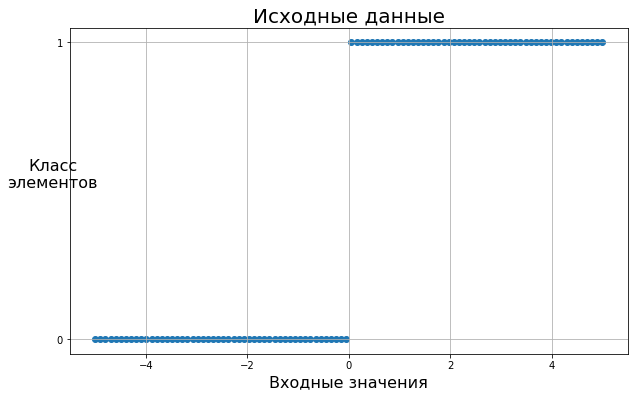

In [4]:
# Общая выборка, с которой мы будем работать
X = np.linspace(-5, 5, num=100)
# Правильные ответ на все данные
y = f(X)
plt.figure(figsize=(10,6))
plt.title("Исходные данные", fontsize=20)
plt.grid()
plt.xlabel("Входные значения", fontsize=16)
plt.ylabel("Класс\nэлементов", fontsize=16, rotation=0)
plt.yticks([0, 1])
plt.scatter(X, y)
plt.show()

In [5]:
# Проверим, что кол-во элементов каждого класса одинаковое
sum = 0
for x in X:
    if x<=0:
        sum -=1
    else:
        sum += 1
print(sum)

0


In [6]:
# Делим выборку на две части -- ту, которая дана нам на обучение и ту, на которой проверим качество работы
X_train, X_test, y_train, y_test = random_sample(X, y)

In [7]:
print(X_train.shape)
print(X_test.shape)

(80,)
(20,)


# Сама модель

Рассмотрим в качестве модели линейный классификатор(1 нейрон) с одной постоянной смещения(в нашем случае она равна 0).

$model(x) = x*w+b$

Затем к выходу будет применяться нелинейный слой активации -- **сигмоида**: $sigmoid(x) = \frac{1}{1+e^{-x}}$

In [8]:
def sigmoid(x, eps=1e-5):
    # TODO: Реализуйте функцию sigmoid(x), 
    # P.S. для возведения экспоненты в степень используйте np.exp()
    return ...

class Net:
    def __init__(self, w=0.5, b=1):
        self.w = w
        self.b = b
    
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        # TODO: реализовать работу сети
        return ...

In [9]:
net = Net(w=0.5, b=1)
print(net(np.array([1])))

[0.81757448]


In [10]:
assert np.abs(sigmoid(-5) - 0.00669) < 0.0001

print("OK")

OK


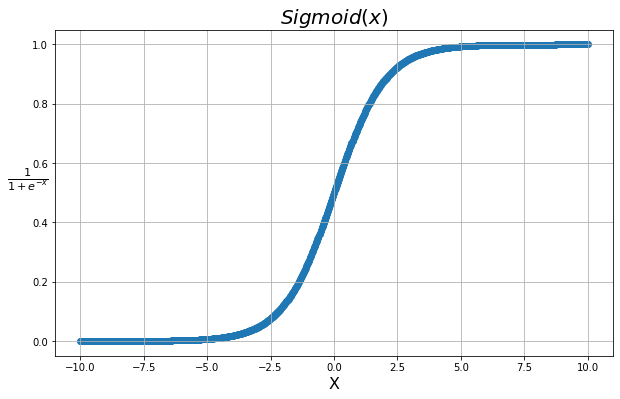

In [11]:
x_sigm = np.linspace(-10, 10, num=1000)
plt.figure(figsize=(10,6))
plt.title("$Sigmoid(x)$", fontsize=20)
plt.grid()
plt.ylabel("$\\frac{1}{1+e^{-x}}$", fontsize=16, rotation=0)
plt.xlabel("X", fontsize=16)
plt.scatter(x_sigm, sigmoid(x_sigm))
plt.show()

# Функция ошибки

$L(x) = -\frac{1}{n}\sum_{i=1}^{n}(y[i]*\log(model(X[i]))+(1-y[i])*\log(1-model(X[i])))$

Реализуем функцию ошибки для одиночного элемента, т.е. 1 слагаемое суммы сверху. Учтем, что из-за больших и малых чисел могут быть переполнения, поэтому в этих местах заменим значение на специально выбранное минимальное допустимое $e^{-5}$. 

In [12]:
def BCELoss(x, y, eps=1e-5):
    # На случай переполнений преобразуем x
    new_x = np.where(x>eps, x, 10)
    ans = np.zeros(x.shape)
    ans[new_x>2] = 1
    new_x = np.where(new_x<1-eps, new_x, -10)
    
    # TODO: реализовать функцию ошибки BCE, как в формуле
    # ВАЖНО -- применяется функция к тем фрагментам, которые больше нуля - другие игнорируются и считаются выбросами 
    # -- т.е. в формуле поменяются x, y на x_1, y_1.
    y_1 = y[new_x>0]
    x_1 = x[new_x>0]
    ans_1 = ...

    ans[new_x>0] = ans_1
    return ans.mean()

In [13]:
assert np.abs(BCELoss(sigmoid(np.array([-5])), np.array([0.00669])) - 0.0401) < 0.0001

print("OK")

OK


## Обратное распространение

Уточним действие сети:

1. Вход домножается на вес **w**: $r_1 = w\times x$;
2. К результату прибавляется константное смещение **b**: $l = w\times x + b$;
3. К полученным значениям применяется преобразование функцией-сигмоидой **r** = $sigmoid(l)$;
4. Ошибка работы оценивается через **BCELoss**, сравнивая **r** с **y** -- известной меткой.

Для обучения сети, как мы уже разбирали, мы должны идти от ошибки и постепенно обновлять веса от последнего слоя к первому.

1. Оцениваем прозводную ошибки на выходе, т.к. решаем градиентным методом: $\frac{\partial L}{\partial r} = -\frac{\partial \left(y*\log(r)+(1-y)*\log(1-r)\right)}{\partial r} = -\frac{y}{r} + \frac{1-y}{1-r}$. Для ее вычисления мы знаем все значения;
2. Теперь переходим к слою активации, т.е. к сигмоиде. Здесь нужно использовать преобразования: $\frac{\partial r}{\partial l}$, где **r** полагаем равным значению сигмоиды от **l**, $\frac{\partial r}{\partial l} = \frac{\partial \frac{1}{1+e^{-l}}}{\partial l} = \frac{e^l(e^l+1)-e^{2l}}{(1+e^{l})^2} = \frac{e^l}{(1+e^{l})^2} = \frac{e^{-l}}{(1+e^{-l})^2} = \frac{1}{1+e^{-l}}*\left(1-\frac{1}{1+e^{-l}}\right) = r(1-r)$. Здесь мы получили значение производной через значение самой функции, поэтому сразу же можем ее вычислить. Далее пользуемся тем фактом, что $\frac{\partial L}{\partial l} = \frac{\partial L}{\partial r} * \frac{\partial r}{\partial l}$;
3. Осталось, наконец получить правильные значения коррекции настраеваемых параметров **w**, **b**: $\frac{\partial l}{\partial w} = \frac{\partial (w\times x + b)}{\partial w} = x$; $\frac{\partial l}{\partial b} = \frac{\partial (w\times x + b)}{\partial b} = 1$. Поэтому для **w** $\frac{\partial L}{\partial w} = \frac{\partial L}{\partial l} * \frac{\partial l}{\partial w} = \frac{\partial L}{\partial r} * r(1-r)*x$; А для **b**: 
$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial l} * \frac{\partial l}{\partial b} = \frac{\partial L}{\partial r} * r(1-r)$

После того, как мы получили значения для производных каждого из весов, можем их менять, руководствуясь тем, о чем говорилось в теории(скорость обучения):

$w = w - \alpha*\frac{\partial L}{\partial w}$

$b = b - \alpha*\frac{\partial L}{\partial b}$

Теперь полученные функции занесем в метод обучения сети.

In [14]:
def backprop(net: Net, x, y, lr=0.01):
    # TODO: Реализовать прямой проход сети
    r = ...
    
    divider_1 = np.where(r>1e-5, r, 1e-5)
    divider_2 = np.where(1-r>1e-5, 1-r, 1e-5)

    # TODO: Посчитать градиент в слое для r -- dL/dr 
    # P.s. r и 1-r заменить на divider_1, divider_2, чтобы избежать ошибок работы с числами
    output_grad = ...
    
    # TODO: Обновить веса для модели, используя значения выше для dL/dw, dL/db
    # P.s. Формулу домножаем на lr[скорость обучения] и берем среднее, чтобы получить 1 число, а не вектор
    net.w -= (lr*output_grad*...).mean()
    net.b -= (lr*output_grad*...).mean()

# Сам процесс обучения

У нас есть данные, на которых мы обучаем модель **X_train**, на которых сравниваем качество в процессе обучения **X_test**

Есть сама модель **Net**, есть функция ошибки **BCELoss**, даже есть функция обновления весов для обучения **backprop**.

Оставим исходными параметрами те, что заданы, обучим модель за 1000 итераций и посмотрим на точность каждой 100-ой итерации.

In [15]:
# Начальное приближение параметров. Почему иначе могут быть проблемы?
net = Net(w=0.7, b=0.1)

# Проебразование типов, чтобы избежать ошибки
X_train = X_train.astype(np.int32)
y_train = y_train.astype(np.int32)
X_test = X_test.astype(np.int32)
y_test = y_test.astype(np.int32)

# Запомним информацию обучения
errs = [] # Ошибки
accs = [] # Точность
wHist = [0.7] # Веса w
bHist = [0.1] # Веса b

print(f'Default quality: BCE={BCELoss(net(X_test), y_test)}, Accuracy = {(net(X_test).round()==y_test).mean()*100}%')
errs.append(BCELoss(net(X_test), y_test))
accs.append((net(X_test).round()==y_test).mean())
for it in range(1000):
    
    # TODO: распространить ошибку сети
    # ВАЖНО -- работаем ТОЛЬКО с обучаемой выборкой, не с тестовой
    ...# что-то от net, X_train и тд


    if it%100 == 0:
        print(net.w)
        print(net.b)
        print(f'Epoch №{it} -- quality: BCE={BCELoss(net(X_test), y_test)}, Accuracy = {(net(X_test).round()==y_test).mean()*100}%')
    errs.append(BCELoss(net(X_test), y_test))
    accs.append((net(X_test).round()==y_test).mean())
    wHist.append(net.w)
    bHist.append(net.b)

print(f'Net.w = {net.w}')
print(f'Net.b = {net.b}')
print(f'Test quality: BCE={BCELoss(net(X_test), y_test)}, Accuracy = {(net(X_test).round()==y_test).mean()*100}%')

Default quality: BCE=0.26759560258735166, Accuracy = 85.0%
0.7025669561069435
0.09990651021784622
Epoch №0 -- quality: BCE=0.2669459390786074, Accuracy = 85.0%
0.9113667069070341
0.0927954027032728
Epoch №100 -- quality: BCE=0.22522476244193687, Accuracy = 85.0%
1.0628545240707319
0.0885693341399171
Epoch №200 -- quality: BCE=0.20525258291622603, Accuracy = 85.0%
1.1836004925263033
0.08604276868676963
Epoch №300 -- quality: BCE=0.19346945984433664, Accuracy = 85.0%
1.2849303361247744
0.08465022710896274
Epoch №400 -- quality: BCE=0.18566384113257298, Accuracy = 85.0%
1.3727659356989645
0.08406667959154397
Epoch №500 -- quality: BCE=0.18009928949346232, Accuracy = 85.0%
1.4506145906513792
0.08408376595780566
Epoch №600 -- quality: BCE=0.1759270407474228, Accuracy = 85.0%
1.5207362094536494
0.08455821689245417
Epoch №700 -- quality: BCE=0.1726818451101277, Accuracy = 85.0%
1.584678410223828
0.08538666278029682
Epoch №800 -- quality: BCE=0.1700866584106832, Accuracy = 85.0%
1.643551041276

# Визуализируем результаты

In [18]:
# Вспомогательная функция для визуализации
def visual_result(x, y, xlabel, ylabel, descr, xticks, yticks=None, secondy=None, fstL = None, sndL = None):
    plt.figure(figsize=(10,6))
    plt.title(descr, fontsize=20)
    plt.grid()
    plt.ylabel(ylabel, fontsize=16, rotation=0)
    plt.xlabel(xlabel, fontsize=16)
    plt.xticks(xticks)
    if yticks is not None:
        plt.yticks(yticks)
    if secondy is not None:
        plt.plot(x, y, '--b', label=fstL)
        plt.plot(x, secondy, 'or', label=sndL)
        plt.legend()
    else:
        plt.plot(x, y)
    plt.show()

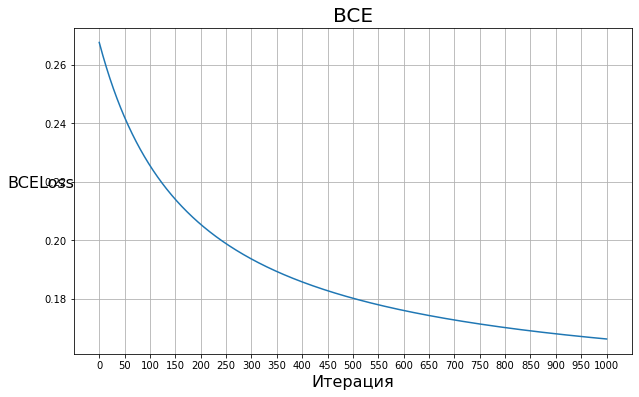

In [19]:
# Как менялась ошибка с итерациями
visual_result(np.arange(1001), errs, "Итерация", "BCELoss", "BCE", np.arange(0, 1001, 50))

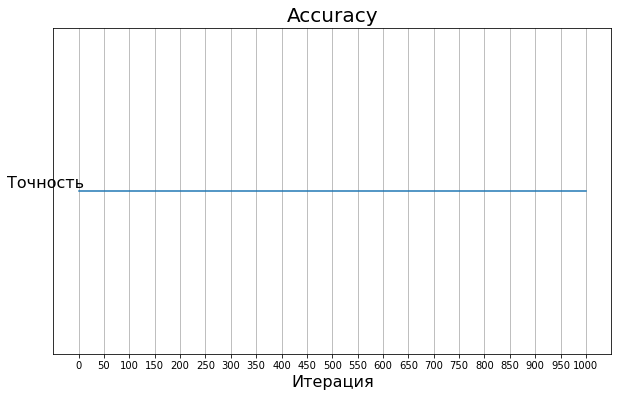

In [20]:
# Как менялась точность с итерациями
visual_result(np.arange(1001), accs, "Итерация", "Точность", "Accuracy", np.arange(0, 1001, 50), yticks=np.arange(0, 101, 10)/100)

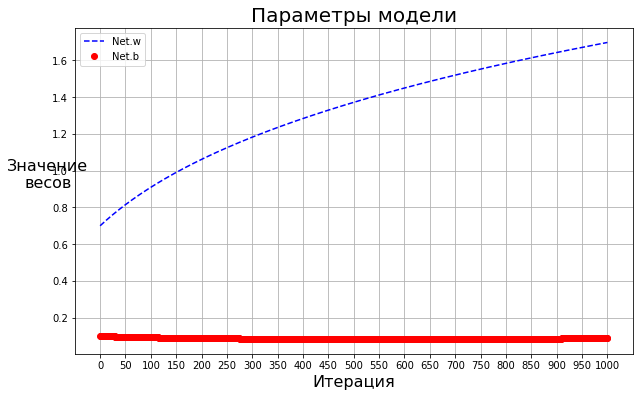

In [21]:
# Как менялись веса модели с итерациями
visual_result(np.arange(1001), wHist, "Итерация", "Значение\nвесов", "Параметры модели", np.arange(0, 1001, 50), 
                secondy=bHist, fstL="Net.w", sndL="Net.b")

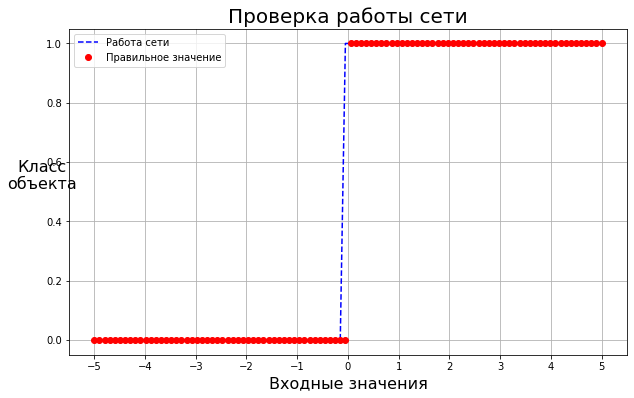

In [22]:
# Как работает итоговая модель и почему 90%
visual_result(X, net(X).round(), "Входные значения", "Класс\nобъекта", "Проверка работы сети", np.arange(-5, 6, 1), secondy=y, fstL="Работа сети", sndL="Правильное значение")